In [1]:
from datasets import load_dataset
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
en_stop_words = set(stopwords.words('english'))
# nltk.download()

from sklearn_crfsuite import CRF

/Users/tina.vu/work/fun/brainstation_capstone_env/brainstation_capstone/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import & prepare dataset

## Import data

We will load laptop reviews dataset with aspect term & sentiment annotations.

The dataset comes in two parts:
- train: 3,048 records
- test: 800 records

Each record is a sentence with zero, one or multiple aspect terms. Each aspect term has the following features:
- start character index
- end character index
- sentiment/ polarity (positive or negative)

In [2]:
dataset = load_dataset("jakartaresearch/semeval-absa", 'laptop')
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'aspects'],
        num_rows: 3048
    })
    validation: Dataset({
        features: ['id', 'text', 'aspects'],
        num_rows: 800
    })
})

In [3]:
dataset.set_format(type='pandas')
df_train = dataset['train'][:]
df_val = dataset['validation'][:]

In [4]:
df_train.head()

,id,text,aspects
0,2339,I charge it at night and skip taking the cord ...,"{'term': ['cord', 'battery life'], 'polarity':..."
1,812,I bought a HP Pavilion DV4-1222nr laptop and h...,"{'term': [''], 'polarity': [''], 'from': [0], ..."
2,1316,The tech guy then said the service center does...,"{'term': ['service center', '""sales"" team', 't..."
3,2328,I investigated netbooks and saw the Toshiba NB...,"{'term': [''], 'polarity': [''], 'from': [0], ..."
4,2193,The other day I had a presentation to do for a...,"{'term': [''], 'polarity': [''], 'from': [0], ..."


## Preparing dataset for modelling

The task we are solving is Named Entity Recognition (NER) which is a sequential labeling task, a.k.a we would like to predict whether a token (word) in each sentence is part of an aspect term or not.

In order to prepare the data for NER task, we need to label our tokens. Here, I applied BIO tagging technique, in which a token is tagged 'X' if a token is:
- 'B': begining of an aspect term
- 'I': part of an aspect term but is not the first word
- 'O': not an aspect term

This BIO label technique is more effective in recognizing unigram and n-gram aspect terms comparing to a binary classification.

First, I will need to drop some duplicated data in our training dataset, as identified in the EDA process.

In [5]:
df_train.drop_duplicates(subset=['text'], inplace=True)

### BIO tagging encode

Here, I defined a function to encode our sentences' aspects using a BIO tagging technique.

Since aspect terms are denoted using character index in a sentence, I need to figure out the word index in the sentence which is the unit I am going to work with for this task.

In [6]:
def find_word_index(sentence, char_index):
    ''''
    Find word index in a sentence base on the character index in a sentence

    -------------------------------
    Parameters:
    -------------------------------
    sentence: str
      a sentence in string format
      e.g. 'I love pizza'

    char_index: int
      index of the character which can be a beginning, mid, or end of a word that you are searching for

    -------------------------------
    Return:
    -------------------------------
    word_index: int
      index of the word which contains the character of char_index in the sentence
    '''
    words = sentence.split()

    # for i, _ in enumerate(words): # Loop through all words in a sentence
    #   total_chars = -1
    #   for w in words[:i+1]:# for each word from beginning of the sentence to word ith
    #     total_chars += len(w) + 1
    #     if char_index <= total_chars:
    #       return i
    # raise Exception(f'char_index({char_index}) > sentence length {len(sentence)} in sentence: "{sentence}"')
       

    return next((i for i, word in enumerate(words) if (char_index - sum(len(w) + 1 for w in words[:i])) < len(word)), len(words) - 1)



In [7]:
def encode_BIO (x):
  '''  This function puts aspect's details into a dictionary, and multiple aspect as an array
  
  Parameter:
  - ASPECTS: json array
    term: string array
    polarity: string array
    from: integer array
    to: integer array

    For example:
      {
        'term': ['cord', 'battery life'], 
        'polarity': ['neutral', 'positive'], 
        'from': [41, 74],
        'to': [45, 86]
      }
      
  Output:
  - PAIRS: dictionary array
    dictionary of
    - term
    - polarity
    - term_start
    - term_end

    For example:
    [
      {'term':'cord', 'polarity':'neutral', 'from': 41, 'to': 45},
      {'term':'battery life', 'polarity':'positive', 'from': 74, 'to': 86}
    ]
  '''
  pairs=list()
  aspects = x['aspects']
  text = x['text']
  text_token = text.split()
  l = len(aspects['term'])

  for i in range(0,l):
    if aspects['term'][i] != '':
      pairs.append(dict({'term': aspects['term'][i]
                        ,'polarity':aspects['polarity'][i]
                        , 'term_start_char':aspects['from'][i]
                        , 'term_end_char':aspects['to'][i]-1
                        , 'term_start':find_word_index(text, aspects['from'][i])
                        , 'term_end':find_word_index(text, aspects['to'][i]-1)
                        }))
  
  aspect_encode = ['O'] * len(text_token)
  
  text_token = [re.sub('[^\w,\d,\s]', ' ', x.lower()) for x in text_token]
  # print(text_token)
  _, pos = zip(*nltk.pos_tag(text_token))

  

  for k in pairs:
    aspect_encode = aspect_encode[:k['term_start']] + ['B'] + ['I'] * (k['term_end'] - k['term_start']) + aspect_encode[k['term_end'] + 1:]
    
  enclosed_aspect_encode = list(zip(text_token, pos, aspect_encode))
  
  return pd.Series([pairs, enclosed_aspect_encode])

In [8]:
# Function to convert sentences into features
def word2features(sent, i, window_size): 
    word = sent[i][0]
    window_size = int((window_size - 1)/ 2 if (window_size % 2) == 1 else window_size / 2)
    
    features = {
        'word.lower()': word.lower(), # word
        'word.index()': i,
        'word.pos': sent[i][1],
        'word.isstopword()': word in en_stop_words,
        'word[-3:]': word[-3:], # last 4 char
        'word[-2:]': word[-2:], # last 3 char - in case of -ing, -ion, etc.
        'word.isupper()': word.isupper(), # is the word in upper case
        'word.istitle()': word.istitle(), # is the first letter of the word in upper case
        'word.isdigit()': word.isdigit(), # is the word full of digit
    }
    if i > 0:
        for k in range(1, min(window_size, i)+1):
            prev_word = sent[i - k][0]
            prev_pos = sent[i - k][1]
            
            features.update({
                f'-{k}:word.lower()': prev_word.lower(),
                f'-{k}:word.pos': prev_pos,
                f'-{k}:word.isstopword()': prev_word in en_stop_words,
                f'-{k}:word.istitle()': prev_word.istitle(),
                f'-{k}:word.isupper()': prev_word.isupper(),
            })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent) - 1:
        for k in range(1, min(window_size, len(sent) - i - 1)+1):
            next_word = sent[i + k][0]
            next_pos = sent[i + k][1]

            features.update({
                f'+{k}:word.lower()': next_word.lower(),
                f'+{k}:word.pos': next_pos,
                f'+{k}:word.isstopword()': next_word in en_stop_words,
                f'+{k}:word.istitle()': next_word.istitle(),
                f'+{k}:word.isupper()': next_word.isupper(),
            })
    else:
        features['EOS'] = True  # End of sentence

    return features

# Function to convert sentences into feature sequences
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [9]:
df_train[['pairs','aspect_encode']] = df_train.apply(lambda x: encode_BIO(x), axis=1)
df_val[['pairs','aspect_encode']] = df_val.apply(lambda x: encode_BIO(x), axis=1)

In [10]:
X_train = [[word2features(sentence, i, 5) for i in range(len(sentence))] for sentence in df_train['aspect_encode']]
y_train = [[ k[2] for k in sentence] for sentence in df_train['aspect_encode']]

X_val = [[word2features(sentence, i, 5) for i in range(len(sentence))] for sentence in df_train['aspect_encode']]
y_val = [[ k[2] for k in sentence] for sentence in df_train['aspect_encode']]

In [11]:
# Create and train CRF model
crf_model = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)
try:
  crf_model.fit(X_train, y_train)
except AttributeError:
  pass

In [12]:
# Test the model with new data
test_text = 'Boot time is super fast, around anywhere from 35 seconds to 1 minute.'
test_sentence =  nltk.pos_tag(test_text.split())
test_features = [word2features(test_sentence, i,5) for i in range(len(test_sentence))]
predicted_labels = crf_model.predict_single(test_features)

print("Predicted labels for the test sentence:", predicted_labels)

Predicted labels for the test sentence: ['B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [22]:
import matplotlib.pyplot as plt
import matplotlib
import random
from highlight_text import HighlightText, ax_text, fig_text

def vizualize_samples (sentences, tags, pred_tags):
    test = ' . '.join(df_val['text'])

    fig, ax = plt.subplots(figsize=(30,10))
    font = {'family' : 'arial',
            'size'   : 16}
    matplotlib.rc('font', **font)
    final_text = []
    color = []

    for x,y in zip(sentences, pred_tags):
        for x1,y1 in zip(x,y):
            if y1!='O':
                final_text.append('<{}>'.format(x1))
                if y1[0]=='I':
                    color.append(color[-1])
                else:
                    color.append ({'color':random.choice(['blue','green','red','magenta'])})
            else:
                final_text.append(x1)

        final_text.append('\n')

    for x,y in zip(sentences, tags):
        for x1,y1 in zip(x,y):
            if y1!='O':
                final_text.append('<{}>'.format(x1))
                if y1[0]=='I':
                    color.append(color[-1])
                else:
                    color.append ({'color':random.choice(['blue','green','red','magenta'])})
            else:
                final_text.append(x1)

        final_text.append('\n')
        
    # You can either create a HighlightText object
    HighlightText(x=0, y=0.75,
                s=' '.join(final_text),
                highlight_textprops=color,
                ax=ax)

    HighlightText(x=0.65, y=0.75,
                s=' '.join(final_text),
                highlight_textprops=color,
                ax=ax)
    plt.axis('off')


317


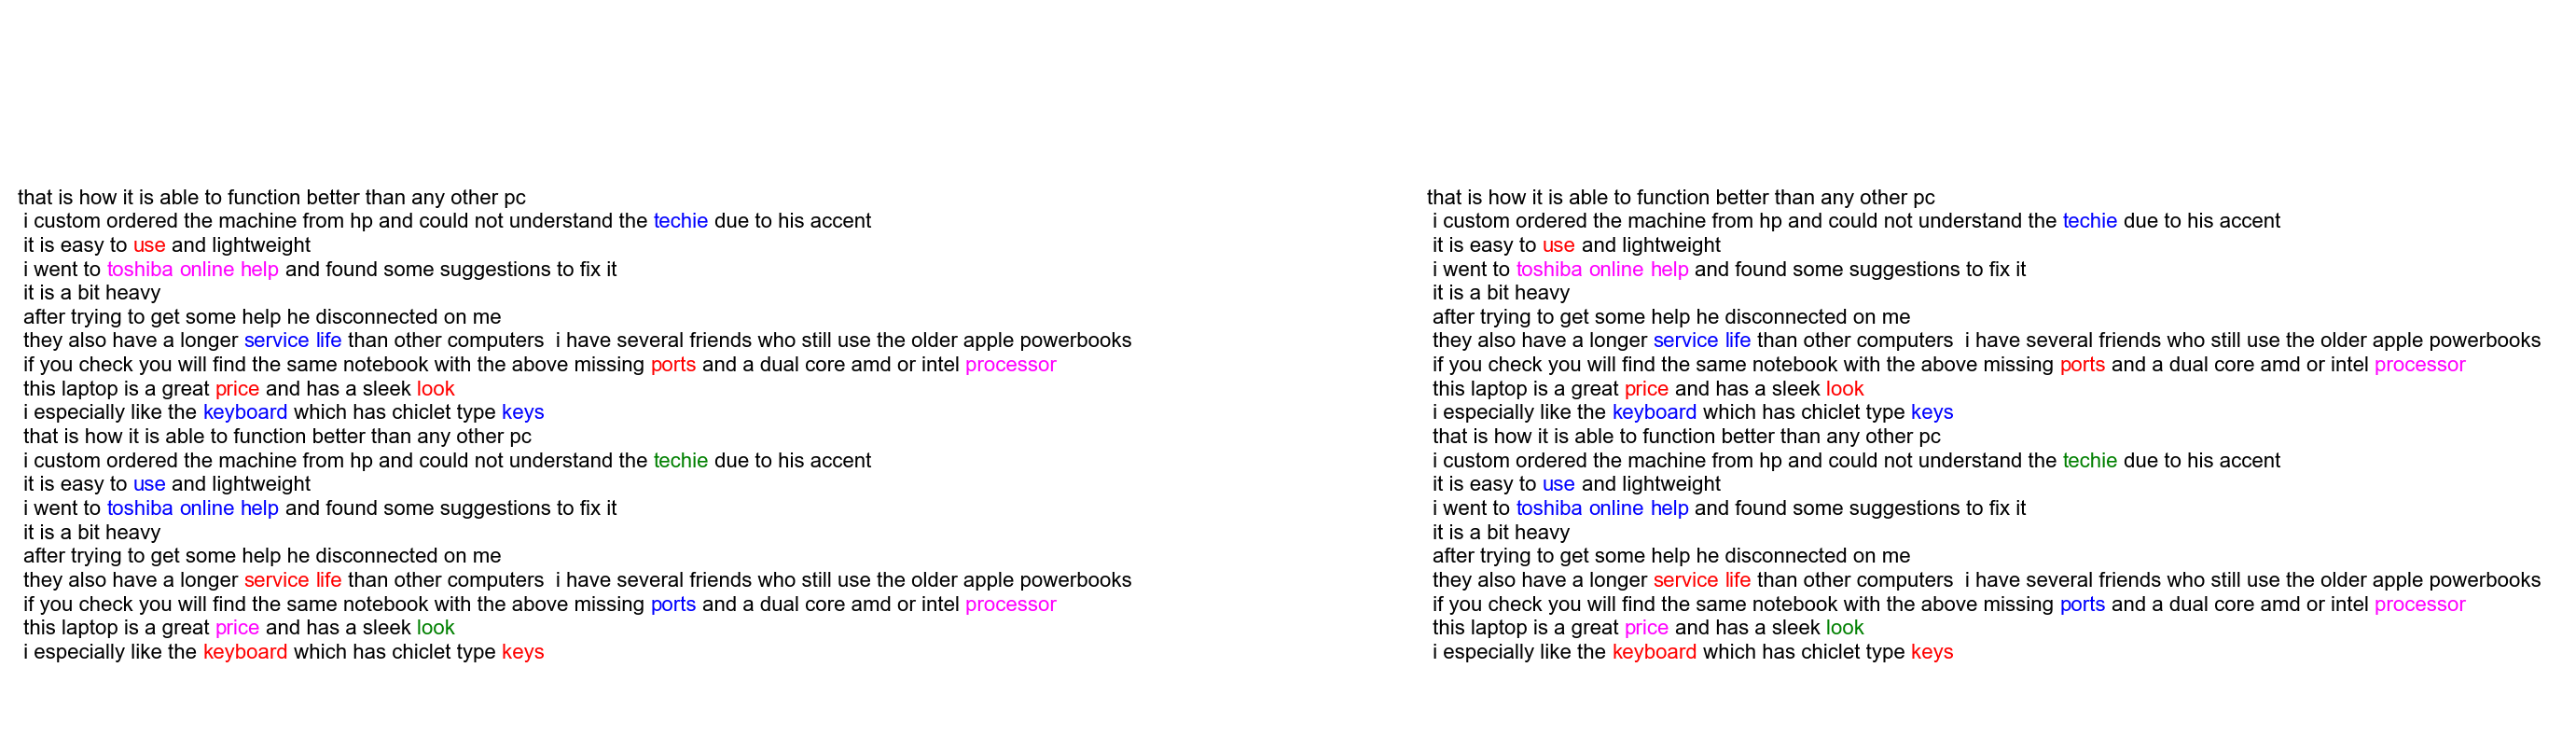

In [23]:
samples = 10
integer = 317 #random.randint(0,500)
tags = y_val[integer:integer+samples]
pred_tags = crf_model.predict(X_val[integer:integer+samples])
sentences = [[x['word.lower()'] for x in sentence] for sentence in X_val[integer:integer+samples]]

print(integer)
vizualize_samples(sentences, tags, pred_tags)

In [24]:
i = 0
nth = integer + i
print(nth)
print(df_train.iloc[nth]['text'])

print(df_train.iloc[nth]['aspects'])

print(df_train.iloc[nth]['pairs'])

print(tags[i])

317
That is how it is able to function better than any other PC.
{'term': array([''], dtype=object), 'polarity': array([''], dtype=object), 'from': array([0], dtype=int16), 'to': array([0], dtype=int16)}
[]
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
